In [1]:
# Basic Libraries
import os
import shutil
import random
import numpy as np
import pandas as pd

# Image Processing
import cv2
from PIL import Image, ImageEnhance
from skimage.util import random_noise

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# TensorFlow and Keras for Deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Attention, Add, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.models import load_model, Sequential

# Scikit-learn for Model Preparation
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Additional Libraries for Image Handling and File Operations
import glob
from glob import glob
import matplotlib.image as mpimg
import pydicom

from tensorflow.keras import layers
from tensorflow.keras.models import load_model, Sequential


print("Imports Complete")

Imports Complete


In [2]:
# Load datasets
df_train = pd.read_csv("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv")
df_train_series_descriptions = pd.read_csv("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv")
df_label_coord = pd.read_csv("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv")
#df_train_imagess = pd.read_csv("/kaggle/working/df_png_paths.csv")

# Load datasets
df_test_series_descriptions = pd.read_csv("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_series_descriptions.csv")
#df_train_imagess = pd.read_csv("/kaggle/working/df_png_paths.csv")

# Output Paths
output_path = '/kaggle/working/train_images'
# Define the directory where your augmented images are saved
augmented_images_dir = '/kaggle/working/augmented_images'

# Path to the input and output directories
input_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/'
test_input_path= '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/'


In [3]:
# Create image paths
df_label_coord['image_path'] = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/" + \
                               df_label_coord['study_id'].astype(str) + "/" + \
                               df_label_coord['series_id'].astype(str) + "/" + \
                               df_label_coord['instance_number'].astype(str) + ".dcm"

# Melt the df_train DataFrame
df_train_melted = df_train.melt(id_vars=['study_id'], var_name='condition_level', value_name='severity')

# Split 'condition_level' to extract 'condition' and 'level'
df_train_melted[['conditions', 'level']] = df_train_melted['condition_level'].str.rsplit('_', n=2, expand=True).iloc[:, 1:]
df_train_melted['condition'] = df_train_melted['condition_level'].apply(lambda x: '_'.join(x.split('_')[:-2])).str.replace("_", " ").str.title()
df_train_melted['level'] = df_train_melted['conditions'].str.upper() + "/" + df_train_melted['level'].str.upper()

# Drop the original 'condition_level' column
df_train_melted = df_train_melted.drop(columns=['condition_level', 'conditions'])

# Merge DataFrames on 'study_id', 'level', and 'condition'
df_final = pd.merge(df_label_coord, df_train_melted, on=['study_id', 'level', 'condition'], how='inner')

# Ensure the 'series_description' column exists before trying to reorder
if 'series_description' in df_train_series_descriptions.columns:
    # Merge df_final with df_train_series_descriptions on 'study_id' and 'series_id'
    df_final_filtered = pd.merge(df_final, df_train_series_descriptions[['study_id', 'series_id', 'series_description']],
                                 on=['study_id', 'series_id'], how='left')

    # Reorder columns to place 'series_description' immediately after 'series_id'
    columns_order = ['study_id', 'series_id', 'series_description', 'instance_number', 'condition', 'level', 'x', 'y', 'image_path', 'severity']
    
    # Ensure that 'series_description' exists in the DataFrame before reordering columns
    if 'series_description' in df_final_filtered.columns:
        df_final_filtered = df_final_filtered[columns_order]
    else:
        print("Warning: 'series_description' column not found after merging.")
else:
    print("Warning: 'series_description' column not found in the input data.")
    
df_final_filtered.sample()

,study_id,series_id,series_description,instance_number,condition,level,x,y,image_path,severity
26980,2427774074,3668699449,Sagittal T1,13,Right Neural Foraminal Narrowing,L2/L3,124.583333,114.666667,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,Moderate


In [4]:
# Path to the output directory
output_path = '/kaggle/working/train_images/'

# Function to convert DICOM pixel array to PNG
def readdcm_writepng_image(src_dicom_pixelarray, dest_path_png):
    src_dicom_pixelarray = np.array(src_dicom_pixelarray)
    standardized_image_data = ((src_dicom_pixelarray - src_dicom_pixelarray.min()) / 
                               (src_dicom_pixelarray.max() - src_dicom_pixelarray.min() + 1e-10)) * 255
    standardized_image_data = standardized_image_data.astype(np.uint8)
    final_image_to_png = cv2.resize(standardized_image_data, (320, 320), interpolation=cv2.INTER_CUBIC)
    cv2.imwrite(dest_path_png, final_image_to_png)

# Remove previous output directory for fresh writing
if os.path.isdir(output_path):
    shutil.rmtree(output_path)

# Drop duplicates based on 'image_path' to ensure each image is converted only once
unique_images_df = df_final_filtered.drop_duplicates(subset='image_path')

# Create a new DataFrame to store paths to the converted images
df_png_paths = pd.DataFrame(columns=df_final_filtered.columns)

# Convert only unique labeled images
for index, row in tqdm(unique_images_df.iterrows(), total=len(unique_images_df)):
    study_id = row['study_id']
    # Apply the replacement to series_description
    series_description = row['series_description'].replace(' ', '_').replace('/', '_')
    instance_number = row['instance_number']
    
    # Construct the destination path for the PNG file
    dest_path = f'{output_path}/{study_id}/{series_description}/{instance_number}.png'
    
    # Ensure directory exists
    os.makedirs(os.path.dirname(dest_path), exist_ok=True)
    
    # Read the DICOM image and convert it to PNG
    dicom_image = pydicom.dcmread(row['image_path'])
    readdcm_writepng_image(dicom_image.pixel_array, dest_path)
    
    # Copy the row and update the image path to the new PNG path
    new_row = row.copy()
    new_row['image_path'] = dest_path
    
    # Replace series_description in the new_row DataFrame
    new_row['series_description'] = series_description
    
    # Append the new row to the new DataFrame using pd.concat
    df_png_paths = pd.concat([df_png_paths, pd.DataFrame([new_row])], ignore_index=True)

print("Conversion to PNG completed.")

# Save the new DataFrame to a CSV file (optional)
df_png_paths.to_csv('/kaggle/working/df_png_paths.csv', index=False)


print("Dataframe saved.")

  0%|          | 0/24546 [00:00<?, ?it/s]/tmp/ipykernel_24/3440978783.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_png_paths = pd.concat([df_png_paths, pd.DataFrame([new_row])], ignore_index=True)
100%|██████████| 24546/24546 [10:28<00:00, 39.04it/s]


Conversion to PNG completed.
Dataframe saved.


In [5]:
from concurrent.futures import ThreadPoolExecutor
from albumentations import (
    HorizontalFlip, VerticalFlip, Rotate, RandomBrightnessContrast,
    ColorJitter, GridDistortion, RandomGamma, GaussNoise, Compose,
    CLAHE, Solarize, Posterize, ShiftScaleRotate, ElasticTransform,
    ToGray, HueSaturationValue
)

# Step 1: Initialise Paths
df_converted_data = pd.read_csv("/kaggle/working/df_png_paths.csv")
output_images_dir = '/kaggle/working/augmented_images'
csv_output_path = '/kaggle/working/df_augmented_final.csv'

# Ensure output directory exists
os.makedirs(output_images_dir, exist_ok=True)

# Step 2: Assume df_png_paths is already defined with the necessary data
# You need to format the series_description
df_augmented = df_png_paths.copy()
df_augmented['series_description'] = df_augmented['series_description'].str.replace(r'[ /]', '_', regex=True)

# Step 3: Define color map augmentation functions
def apply_color_map(image, colormap):
    return cv2.applyColorMap(image, colormap)

# Step 4: Define augmentation techniques
albumentations_augmentations = [
    Compose([Rotate(limit=90), HorizontalFlip()]),
    Compose([Rotate(limit=180)]),
    Compose([Rotate(limit=270), HorizontalFlip()]),
    Compose([ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)]),
    Compose([GaussNoise(), VerticalFlip()]),
    Compose([GridDistortion()]),
    Compose([ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15)]),
    Compose([ElasticTransform(alpha=1, sigma=50, alpha_affine=None)]),  # Updated line
    Compose([CLAHE(), HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20)]),
    Compose([Solarize(threshold=128.0), Posterize(num_bits=4)]),
    Compose([ToGray()])
]

color_map_augmentations = [
    (cv2.COLORMAP_VIRIDIS, 'viridis'),
    (cv2.COLORMAP_PLASMA, 'plasma'),
    (cv2.COLORMAP_INFERNO, 'inferno'),
    (cv2.COLORMAP_MAGMA, 'magma'),
]

# Combine all augmentations into one list
all_augmentations = albumentations_augmentations + color_map_augmentations

# Define how many times to augment each image for Moderate and Severe classes
num_augmentations_per_image_severe = 10 # Augment each 'Severe' image 6 times
num_augmentations_per_image_moderate = 4  # Augment each 'Moderate' image 1 time

def augment_image(row):
    image_path = row['image_path']
    image = cv2.imread(image_path)  # Load the image using OpenCV

    # Check if the image was loaded successfully
    if image is None:
        print(f"Warning: Unable to load image at path: {image_path}")
        return []  # Return an empty list if the image could not be loaded

    coords = [row['x'], row['y']]  # Extract coordinates
    augmented_images = []  # Store augmented images for this row
    image_height, image_width = image.shape[:2]

    # Determine the number of augmentations based on severity
    if row['severity'] == 'Severe':
        num_augmentations = num_augmentations_per_image_severe
    elif row['severity'] == 'Moderate':
        num_augmentations = num_augmentations_per_image_moderate
    else:
        return []  # Skip if severity is not 'Moderate' or 'Severe'

    for _ in range(num_augmentations):
        # Choose an augmentation
        aug_index = np.random.choice(len(all_augmentations))
        aug = all_augmentations[aug_index]

        try:
            if isinstance(aug, tuple):
                # Apply the color map augmentation
                colormap, name = aug
                image_aug = apply_color_map(image, colormap)
                aug_name = name  # Use the color map name directly
            else:
                # Apply the Albumentations augmentation
                augmented = aug(image=image)
                image_aug = augmented['image']

                # Get the augmentation names
                aug_name = '_'.join([type(t).__name__ for t in aug.transforms])

                # Update coordinates based on the applied transformations
                for t in aug.transforms:
                    if isinstance(t, HorizontalFlip):
                        coords[0] = image_width - coords[0]
                    if isinstance(t, VerticalFlip):
                        coords[1] = image_height - coords[1]
                    if isinstance(t, Rotate):
                        angle = t.limit if isinstance(t.limit, (int, float)) else t.limit[1]
                        if angle == 90:
                            coords = [coords[1], image_width - coords[0]]
                        elif angle == 180:
                            coords = [image_width - coords[0], image_height - coords[1]]
                        elif angle == 270:
                            coords = [image_height - coords[1], coords[0]]

            # Create subfolder structure
            study_id = row['study_id']
            series_id = row['series_id']
            series_description = row['series_description'].replace(' ', '_')  # Replace spaces with underscores
            output_subfolder = os.path.join(output_images_dir, str(study_id), series_description)
            os.makedirs(output_subfolder, exist_ok=True)

            # Generate new file name with the augmentation name and instance number
            instance_number = row['instance_number']
            augmented_image_path = os.path.join(output_subfolder, f"{aug_name}_{instance_number}.png")

            # Save the augmented image
            cv2.imwrite(augmented_image_path, image_aug)

            augmented_images.append({
                'study_id': study_id,
                'series_id': series_id,
                'series_description': series_description,
                'instance_number': instance_number,
                'x': coords[0],
                'y': coords[1],
                'condition': row['condition'],
                'level': row['level'],
                'image_path': augmented_image_path,
                'severity': row['severity']
            })
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

    return augmented_images


# Step 7: Filter only Moderate and Severe classes for augmentation
df_filtered = df_augmented[df_augmented['severity'].isin(['Moderate', 'Severe'])]

# Step 8: Use parallel processing to augment images
augmented_data = []

with ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(augment_image, [row for _, row in df_filtered.iterrows()]), total=len(df_filtered)))

# Flatten the results and filter out None values
augmented_data = [item for sublist in results for item in sublist if item is not None]

# Step 9: Collect the results into a DataFrame
df_augmented_final = pd.DataFrame(augmented_data)

# Save the augmented DataFrame to a CSV file
df_augmented_final.to_csv(csv_output_path, index=False)

print(f"Total processed images: {len(augmented_data)}")


/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:49: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
100%|██████████| 5418/5418 [01:54<00:00, 47.29it/s]


Total processed images: 31494


In [6]:
df_png_paths["severity"].value_counts()

severity
Normal/Mild    19108
Moderate        3781
Severe          1637
Name: count, dtype: int64

In [7]:
# Drop rows with severity equal to 0 or NaN
df_final_filtered_cleaned = df_png_paths[(df_png_paths['severity'] != 0) & (df_png_paths['severity'].notna())]
df_augmented_cleaned = df_augmented_final[(df_augmented_final['severity'] != 0) & (df_augmented_final['severity'].notna())]

# Display the resulting DataFrame
print(f"Data after removing rows with severity 0 or NaN: {df_final_filtered_cleaned.shape[0]} samples")
print(f"Data after removing rows with severity 0 or NaN: {df_augmented_cleaned.shape[0]} samples")

# Concatenate the cleaned DataFrames
df_concat = pd.concat([df_final_filtered_cleaned, df_augmented_cleaned], ignore_index=True)

# Check the class distribution after balancing
print(df_concat["severity"].value_counts())

Data after removing rows with severity 0 or NaN: 24526 samples
Data after removing rows with severity 0 or NaN: 31494 samples
severity
Normal/Mild    19108
Moderate       18905
Severe         18007
Name: count, dtype: int64


In [8]:
# Count current instances in each class
print(df_concat["severity"].value_counts())

# Define the target number for balancing (the maximum count from 'Normal/Mild')
target_count = df_concat["severity"].value_counts().max()

# Oversampling the 'Severe' and 'Moderate' classes
df_severe = df_concat[df_concat["severity"] == "Severe"]
df_moderate = df_concat[df_concat["severity"] == "Moderate"]
df_normal_mild = df_concat[df_concat["severity"] == "Normal/Mild"]

# Create balanced DataFrames by oversampling
df_severe_oversampled = df_severe.sample(target_count, replace=True, random_state=42)
df_moderate_oversampled = df_moderate.sample(target_count, replace=True, random_state=42)

# Combine all classes into a single DataFrame
df_balanced = pd.concat([df_normal_mild, df_severe_oversampled, df_moderate_oversampled], ignore_index=True)

# Shuffle the balanced DataFrame
df_resampled = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the class distribution after balancing
print(df_resampled["severity"].value_counts())

severity
Normal/Mild    19108
Moderate       18905
Severe         18007
Name: count, dtype: int64
severity
Severe         19108
Normal/Mild    19108
Moderate       19108
Name: count, dtype: int64


In [9]:
# List to store paths of corrupted files
corrupted_files = []

# Check each image in the dataset
for index, row in df_resampled.iterrows():
    img_path = row['image_path']
    try:
        # Try to open the image file
        img = Image.open(img_path)
        img.verify()  # Verify that it is a valid image
    except (IOError, SyntaxError) as e:
        corrupted_files.append(img_path)

# Remove corrupted files from the DataFrame
df_resampled_cleaned = df_resampled[~df_resampled['image_path'].isin(corrupted_files)]

# Create the final augmented DataFrame with cleaned data
df_dataset = df_resampled_cleaned.copy()

# Print the number of corrupted files found and removed
print(f"Number of corrupted files removed: {len(corrupted_files)}")

# Print the number of valid rows in the final DataFrame
print(f"Number of valid rows in the final DataFrame: {df_dataset.shape[0]}")

Number of corrupted files removed: 3
Number of valid rows in the final DataFrame: 57321


In [10]:
# Split the data into training, validation, and test sets
train_df, test_df = train_test_split(df_resampled_cleaned, test_size=0.3, stratify=df_resampled_cleaned['severity'])
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['severity'])

# Create ImageDataGenerator with rescaling
datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for train, validation, and test sets
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='severity',
    target_size=(320, 320),  # Resize images to 256x256
    batch_size=6,            # Batch size for training
    class_mode='categorical', # Use 'categorical' for multi-class classification
    shuffle=True              # Shuffle the training data
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='severity',
    target_size=(320, 320),  # Resize images to 256x256
    batch_size=6,            # Batch size for validation
    class_mode='categorical', # Use 'categorical' for multi-class classification
    shuffle=False              # Do not shuffle validation data
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='severity',
    target_size=(320, 320),  # Resize images to 256x256
    batch_size=6,            # Batch size for testing
    class_mode='categorical', # Use 'categorical' for multi-class classification
    shuffle=False              # Do not shuffle test data
)

# Set the class names
class_names = ['Moderate', 'Normal/Mild', 'Severe']

Found 32099 validated image filenames belonging to 3 classes.
Found 8025 validated image filenames belonging to 3 classes.
Found 17197 validated image filenames belonging to 3 classes.


In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf

# Build the CNN model
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(320, 320, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(3, activation='softmax')
])

# Compile the model using categorical crossentropy
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()

# Fit the model and capture the history
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    verbose=1
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 318, 318, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 159, 159, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 157, 157, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 78, 78, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 76, 76, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 38, 38, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 184832)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,658,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,752,259 (90.61 MB)

 Trainable params: 23,752,259 (90.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726141758.699596      78 service.cc:145] XLA service 0x799438005740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726141758.699669      78 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   9/5350 ━━━━━━━━━━━━━━━━━━━━ 2:00 23ms/step - accuracy: 0.2911 - loss: 1.0944

I0000 00:00:1726141763.092762      78 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5350/5350 ━━━━━━━━━━━━━━━━━━━━ 173s 31ms/step - accuracy: 0.4999 - loss: 0.9701 - val_accuracy: 0.5849 - val_loss: 0.8429
Epoch 2/20
5350/5350 ━━━━━━━━━━━━━━━━━━━━ 164s 31ms/step - accuracy: 0.5993 - loss: 0.8354 - val_accuracy: 0.6243 - val_loss: 0.7877
Epoch 3/20
5350/5350 ━━━━━━━━━━━━━━━━━━━━ 159s 30ms/step - accuracy: 0.6397 - loss: 0.7695 - val_accuracy: 0.6523 - val_loss: 0.7324
Epoch 4/20
5350/5350 ━━━━━━━━━━━━━━━━━━━━ 164s 31ms/step - accuracy: 0.6787 - loss: 0.7013 - val_accuracy: 0.6819 - val_loss: 0.6871
Epoch 5/20
5350/5350 ━━━━━━━━━━━━━━━━━━━━ 165s 31ms/step - accuracy: 0.7191 - loss: 0.6412 - val_accuracy: 0.7257 - val_loss: 0.6297
Epoch 6/20
5350/5350 ━━━━━━━━━━━━━━━━━━━━ 165s 31ms/step - accuracy: 0.7625 - loss: 0.5625 - val_accuracy: 0.7431 - val_loss: 0.5886
Epoch 7/20
5350/5350 ━━━━━━━━━━━━━━━━━━━━ 170s 32ms/step - accuracy: 0.7886 - loss: 0.5099 - val_accuracy: 0.7707 - val_loss: 0.5485
Epoch 8/20
5350/5350 ━━━━━━━━━━━━━━━━━━━━ 171s 32ms/step - accuracy: 0.8185 - lo

In [12]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2867/2867 ━━━━━━━━━━━━━━━━━━━━ 72s 25ms/step - accuracy: 0.8927 - loss: 0.4078
Test Loss: 0.39662662148475647
Test Accuracy: 0.8962609767913818


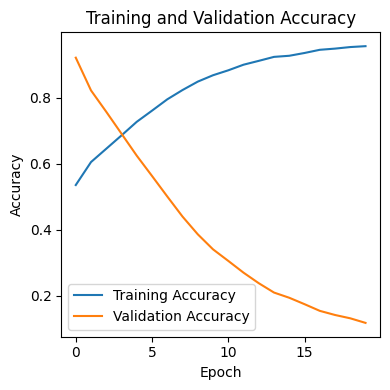

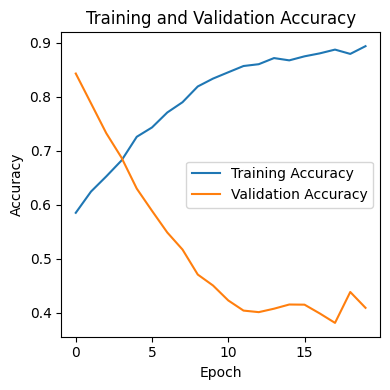

In [13]:
# Plot Training & Validation Loss
plt.figure(figsize=(4, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
# Assuming 'history' is the variable where you stored the output of model.fit

# Plot Training & Validation Loss
plt.figure(figsize=(4, 4))
plt.plot(history.history['val_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_loss'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
df_test_series = pd.read_csv("/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_series_descriptions.csv")
test_images_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images'
output_path = '/kaggle/working/RSNA_test_images_png/'

# Remove the output directory if it exists (for fresh conversion)
if os.path.isdir(output_path):
    shutil.rmtree(output_path)

# Iterate over the test data
for idx, row in tqdm(df_test_series.iterrows(), total=len(df_test_series)):
    study_id = row['study_id']
    series_id = row['series_id']
    series_desc = row['series_description'].replace(' ', '_').replace('/', '_')
    
    # Define the new directory structure for PNGs
    series_output_dir = f'{output_path}/{study_id}/{series_desc}'
    os.makedirs(series_output_dir, exist_ok=True)
    
    # Get all DICOM files in this series
    series_dicom_dir = f'{test_images_path}/{study_id}/{series_id}'
    dicom_files = glob(f'{series_dicom_dir}/*.dcm')
    
    # Convert each DICOM file to PNG
    for dicom_file in dicom_files:
        dicom_image = pydicom.dcmread(dicom_file)
        image_filename = os.path.splitext(os.path.basename(dicom_file))[0]  # Use SOPInstanceUID for naming
        image_dicom_pixelarray = dicom_image.pixel_array
        
        dest_path = f'{series_output_dir}/{image_filename}.png'
        readdcm_writepng_image(image_dicom_pixelarray, dest_path)

100%|██████████| 3/3 [00:02<00:00,  1.05it/s]


In [15]:
# Load the new CSV file with study descriptions
df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_series_descriptions.csv')

# Define conditions and levels
CONDITIONS = [
    'spinal_canal_stenosis', 
    'left_neural_foraminal_narrowing', 
    'right_neural_foraminal_narrowing',
    'left_subarticular_stenosis',
    'right_subarticular_stenosis'
]
LEVELS = [
    'l1_l2',
    'l2_l3',
    'l3_l4',
    'l4_l5',
    'l5_s1',
]


def preprocess_image(img_path):
    """Preprocess an image for model prediction."""
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        return None
    img_resized = cv2.resize(img, (320, 320))  # Resize
    img_normalized = img_resized / 255.0  # Normalize
    return img_normalized

def get_image_paths(directory):
    """Retrieve all PNG image paths from a directory."""
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.png'):
                image_paths.append(os.path.join(root, file))
    return image_paths

def predict(img_paths):
    """Predict spinal condition severity for a list of images."""
    processed_images = [preprocess_image(path) for path in img_paths if preprocess_image(path) is not None]
    if not processed_images:
        return []
    processed_images_array = np.array(processed_images)
    predictions = model.predict(processed_images_array)
    return predictions.tolist()  # Convert predictions to a list

# Create a list to store the rows for the submission
submission_data = []

# Iterate through each unique study_id in the new CSV
for study_id in df["study_id"].unique():
    for condition in CONDITIONS:
        for level in LEVELS:
            row_id = "_".join([str(study_id), condition, level])
            image_dir = f"/kaggle/working/RSNA_test_images_png/{study_id}"
            
            if not os.path.exists(image_dir):
                continue

            image_paths = get_image_paths(image_dir)
            if not image_paths:
                continue
            
            # Get predictions for each image in the directory
            preds = predict(image_paths)
            
            if preds:
                # Add predictions to the list for each image
                for pred in preds:
                    submission_data.append([row_id, *pred])
            else:
                # Default values if no predictions are available
                submission_data.append([row_id, 0, 0, 0])

# Create the submission DataFrame with the correct columns
submission_df = pd.DataFrame(submission_data, columns=["row_id", "normal_mild", "moderate", "severe"])

# Save to CSV
submission_df.to_csv('submission1.csv', index=False)

print("Submission DataFrame preview:")
print(submission_df.head(20))


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Submission DataFrame preview:
                   